# Homework 3: Inference with Linear Regression & Multiple Linear Regression (50 points)

Please complete this notebook by filling in the cells provided.

The solved homework should be uploaded to Gradescope as an .ipynb file. DO NOT put your answers in more than one file or use a different file extension.

**<u>Deadline</u>**:

This assignment is due on **Friday, April 12** at **11:59pm**.

- Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged.

- You should start early so that you have time to get help if you're stuck.

- Submit your homework 30-60 minutes to ensure that it will upload before the deadline.

- Please run all of your code cells and ensure all of your answers are outputted and visible to graders.

- Check the file preview on Gradescope to make sure all of your answers are visible.

- Be mindful of your file sizes. Do not print out entire large datasets use .head or .tail instead. Make sure your document is visible in the Gradescope preview.

- Your functions should have a docstring. Points may be taken off for not including a docstring.

- Your graphs should be labeled with a title, x-label, and y-label and be otherwise readable. Intervals on x- and y-axises should make sense for the data. If these items are missing, points may be taken off.

In [4]:
# Don't change this cell; just run it.
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#new module (library)
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

In [5]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x))/np.std(x,ddof=1)  

def correlation(x, y):
    x_in_standard_units = standard_units(x)
    y_in_standard_units = standard_units(y)
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return sum(x_in_standard_units * y_in_standard_units)/(len(x)-1)

def slope(x, y):
    if len(x)!=len(y):
        raise ValueError('arrays are of different lengths')
    return  correlation(x, y)* np.std(y,ddof=1)/np.std(x,ddof=1)

def intercept(x, y):
    b1 = slope(x, y)
    return np.average(y) - b1 * np.average(x)

def fitted_values(x, y):
    """Return an array of the regressions estimates at all the x values"""
    b1 = slope(x, y)
    b0 = intercept(x, y)
    return b1*x + b0

def residuals(x, y):
    return y - fitted_values(x, y)

## 1. Simulations and Confidence Intervals (8 points)

In this exercise we will construct confidence intervals for the population correlation parameter and we will use simulations to assess the validity of our procedure.

The following cell contains a function that generates a dataset of sample size n from a population with correlation parameter equal to r.

In [6]:
def cor_sim(r,n):
    x = np.random.normal(0, 1, n)
    z = np.random.normal(0, 1, n)
    y = r*x + np.sqrt(1 - r**2)*z
    df = pd.DataFrame()
    df['X'] = x
    df['Y'] = y
    return df

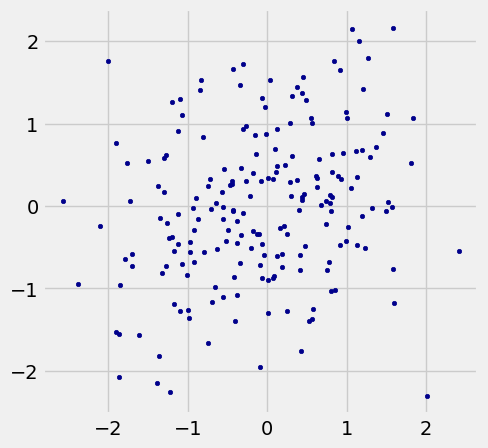

In [7]:
# run this to get a scatter plot of a simulated dataset
sim1_df=cor_sim(0.3,200)

plt.figure(figsize=(5,5))
plt.scatter(sim1_df.X, sim1_df.Y, s=10,c='darkblue')

plt.show()

**Question 1. (3pts)** Write a function that calculates (for two given variables reflected in two columns of a data frame) a 95% confidence interval for the population correlation. Then calculate a bootstrap 95% CI for a dataset simulated with the function above. (You can use percentile or basic bootstrap)

In [8]:
def bootstrap_correlation(df, x, y, repetitions):
    '''a function that outputs a 95% CI for the correlation
     inputs are: a data frame, the name of the two columns, and number of bootstraps
     output is: an array of length three containing the correlation, and also
     the left and right ends of the 95% CI'''
    x_data = df[x]
    y_data = df[y]
    
    slope_estimates = []
    
    n = df.shape[0]
    
    for i in range(repetitions):
        bootstrap_indices = np.random.choice(n, n, replace=True)
        x_bootstrap = x_data.iloc[bootstrap_indices]
        y_bootstrap = y_data.iloc[bootstrap_indices]
        
        slope_estimates.append(correlation(x_bootstrap, y_bootstrap))
        
    
    lower_confidence_interval = np.percentile(slope_estimates, 2.5)
    upper_confidence_interval = np.percentile(slope_estimates, 97.5)
    
    return (lower_confidence_interval, upper_confidence_interval)
    

In [9]:
# run this cell to get a confidence interval for one simulated dataset

# a simulated data frame with population correlation 0.3
sim1_df=cor_sim(0.3,200)

bootstrap_correlation(sim1_df,'X','Y',1000)

(0.16466579681720106, 0.426239142809534)

**Question 2 (3pts)** Repeat this procedure 100 times with the same specifications (n=200, r=0.3) and construct a data frame that has 100 rows (one for each simulation) and three columns:

- ObsCor: which contains the observed correlations in each simulated datasets;
- Left: contains the left ends of the 95% confidence intervals;
- Right: contains the right ends of the 95% confidence intervals.

In [10]:
def simulate_correlations(r, n, repetitions):
    '''Takes in a correlation coefficient, the size of a dataset, and a # of repetitions and returns a dataframe
    that has "repetitions" rows and 3 columns: 'ObsCor', 'Left', and 'Right'.'''
    
    ObsCor = []
    Left = []
    Right = []
    
    sim_df = cor_sim(r, n)
    
    for i in range(repetitions):
        
        bootstrap_indices = np.random.choice(n, n, replace=True)
        x_bootstrap = sim_df['X'].iloc[bootstrap_indices]
        y_bootstrap = sim_df['Y'].iloc[bootstrap_indices]
        
        observed_corr = correlation(x_bootstrap, y_bootstrap)
        ObsCor.append(observed_corr)
        
        bootstrap_result = bootstrap_correlation(sim_df, 'X', 'Y', repetitions)
        Left.append(bootstrap_result[0])
        Right.append(bootstrap_result[1])
        
    return pd.DataFrame({'ObsCor': ObsCor, 'Left': Left, 'Right': Right})

    

In [13]:
result_df = simulate_correlations(0.3, 200, 100)

result_df

,ObsCor,Left,Right
0,0.271955,0.133204,0.368807
1,0.289556,0.125819,0.360775
2,0.165941,0.131896,0.391468
3,0.178444,0.150574,0.355918
4,0.318904,0.130622,0.381971
...,...,...,...
95,0.166947,0.135977,0.376527
96,0.295064,0.127639,0.365026
97,0.297859,0.133858,0.349052
98,0.262024,0.136216,0.376991


**Question 3. (2pts)** Calculate the number of intervals that contain the population value of the correlation (r=0.3). Is this number consistent with your expectation? 

In [14]:
count = 0
for index, row in result_df.iterrows():
    if row['Left'] <= 0.3 <= row['Right']:
            count += 1

count

100

Out of the 100 intervals that I calculated, 100 of them contain the population value of the correlation (r = 0.3). This is fairly expected, as the function "bootstrap_slope" calculates a 95% confidence interval, which is close enough to 100%, the empirical value I calculated above.

## 2. Birthweight Prediction (42 points)

A dataset was collected at Baystate Medical Center, Springfield, Massachusetts during 1986 that contains the following variables:

- low: indicator of birth weight less than 2.5 kg.
- age: mother’s age in years.
- lwt: mother’s weight in pounds at last menstrual period.
- race: mother’s race (1 = white, 2 = black, 3 = other).
- smoke: smoking status during pregnancy.
- ptl: number of previous premature labours.
- ht: history of hypertension.
- ui: presence of uterine irritability.
- ftv: number of physician visits during the first trimester.
- bwt: birth weight in grams.

For original data 0 is no, 1 is yes.

You can find more informationabout it here: https://vincentarelbundock.github.io/Rdatasets/doc/MASS/birthwt.html

In [15]:
births_df=pd.read_csv("../data/birthwt.csv")
births_df.head(10)

,Unnamed: 0,low,age,lwt,race,smoke,ptl,ht,ui,ftv,bwt
0,85,0,19,182,2,0,0,0,1,0,2523
1,86,0,33,155,3,0,0,0,0,3,2551
2,87,0,20,105,1,1,0,0,0,1,2557
3,88,0,21,108,1,1,0,0,1,2,2594
4,89,0,18,107,1,1,0,0,1,0,2600
5,91,0,21,124,3,0,0,0,0,0,2622
6,92,0,22,118,1,0,0,0,0,1,2637
7,93,0,17,103,3,0,0,0,0,1,2637
8,94,0,29,123,1,1,0,0,0,1,2663
9,95,0,26,113,1,1,0,0,0,0,2665


**Question 4. (4 pts)** Review the variables to identify which are numeric and which are categorical. Convert any
categorical variables into numeric dummy variables.

In [16]:
births_df = pd.get_dummies(births_df, columns=['race', 'smoke', 'ht', 'ui'], dtype = 'float', drop_first=True)
births_df

,Unnamed: 0,low,age,lwt,ptl,ftv,bwt,race_2,race_3,smoke_1,ht_1,ui_1
0,85,0,19,182,0,0,2523,1.0,0.0,0.0,0.0,1.0
1,86,0,33,155,0,3,2551,0.0,1.0,0.0,0.0,0.0
2,87,0,20,105,0,1,2557,0.0,0.0,1.0,0.0,0.0
3,88,0,21,108,0,2,2594,0.0,0.0,1.0,0.0,1.0
4,89,0,18,107,0,0,2600,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
184,79,1,28,95,0,2,2466,0.0,0.0,1.0,0.0,0.0
185,81,1,14,100,0,2,2495,0.0,1.0,0.0,0.0,0.0
186,82,1,23,94,0,0,2495,0.0,1.0,1.0,0.0,0.0
187,83,1,17,142,0,0,2495,1.0,0.0,0.0,1.0,0.0


**Question 5 (10pts)** Fit a simple linear regression model for `Mother's weight` (lwt) (as the predictor) and `Birth Weight` (bwt) (as the response). Calculate the 

(a) (1pt) intercept

(b) (1pt) the slope 

(c) (3pts) and a 95% Confidence Interval for the slope (you can use basic or percentile)

Briefly discuss your results by: 

(i) (1pts) interpreting the slope; 

(ii) (3pts) discussing the significance of the predictor (is there evidence that the slope is different than 0?) Clearly specify the null and alternative hypothesis, and if you reject or fail to reject the null.; 

(iii)(1pt) commenting on whether the results make sense (does it make sense for birth weight to be associated with mother's weight?).


In [17]:
def bootstrap_slope(df, x, y, repetitions):
    '''a function that outputs a 95% CI for the slope between two sets
     inputs are: a data frame, the name of the two columns, and number of bootstraps
     output is: an array of length three containing the correlation, and also
     the left and right ends of the 95% CI'''
    x_data = df[x]
    y_data = df[y]
    
    slope_estimates = []
    
    n = df.shape[0]
    
    for i in range(repetitions):
        bootstrap_indices = np.random.choice(n, n, replace=True)
        x_bootstrap = x_data.iloc[bootstrap_indices]
        y_bootstrap = y_data.iloc[bootstrap_indices]
        
        slope_estimates.append(slope(x_bootstrap, y_bootstrap))
        
    
    lower_confidence_interval = np.percentile(slope_estimates, 2.5)
    upper_confidence_interval = np.percentile(slope_estimates, 97.5)
    
    return (lower_confidence_interval, upper_confidence_interval)

In [18]:
model = LinearRegression().fit(births_df[['lwt']], births_df['bwt'])

b = model.intercept_
m = model.coef_[0]
print(f"The slope-intercept form line of a simple linear regression model for Mother's weight vs. Birth weight would be y = {m}x + {b}")


The slope-intercept form line of a simple linear regression model for Mother's weight vs. Birth weight would be y = 4.429107606350701x + 2369.6235178739976


In [19]:
confidence_interval = bootstrap_slope(births_df, 'lwt', 'bwt', 500)
print(f"A 95% Confidence Interval for the slope of the linear regression model is: {confidence_interval}")

A 95% Confidence Interval for the slope of the linear regression model is: (1.898634153316593, 7.360760459342167)


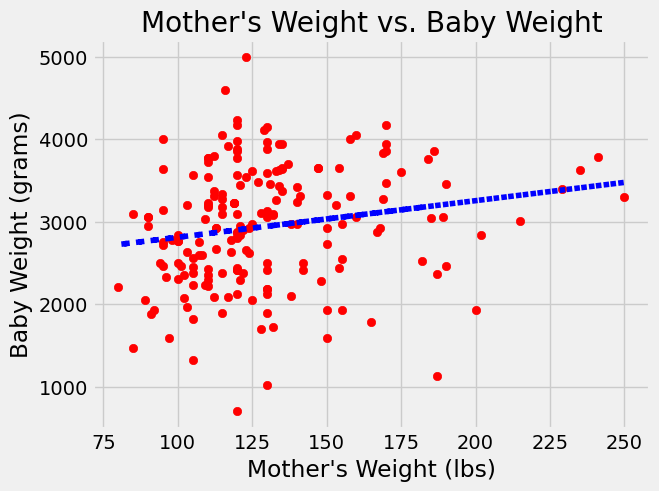

In [20]:
plt.scatter(births_df.lwt, births_df.bwt, color = 'red')

plt.plot(births_df.lwt, m * births_df.lwt + b, color = 'blue', linestyle='dotted')

plt.xlabel("Mother's Weight (lbs)")
plt.ylabel("Baby Weight (grams)")

plt.title("Mother's Weight vs. Baby Weight")

plt.show()

Interpretation of Slope: In the context of this linear regression model, which compares mother's weight (in lbs) with their respective baby's weight (in grams), the slope of ~4.29 means that for every 1-pound increase in Mother's weight, their baby's weight, on average, increases by 4.29 grams.

Significance of the Predictor:
Null Hypothesis: β1=0
Alternative Hypothesis: β1≠0

Given that the 95% Confidence Interval I calculated for the slope between Mother's weight and Baby Weight ([1.2995488399164978, 7.286724608151909]) does not contain zero, we can reject our null hypothesis and affirm the alternative, that there is a non-zero correlation between the two variables.

I would say the results make some sense. It seems intuitive that there would be some sort of correlation between the two variables, even if it's not very significant (a change in ~4 grams is not a very large change).

**Question 6. (3pts)** A correlation matrix shows all of the pairwise correlations for a set of variables. Find the correlation matrix for the numeric variables in this dataset (other than the dummy variables you just created). Are there any predictors that could be considered collinear?

Hint: See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html and/or https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html  

In [24]:
births_df = births_df.rename(columns={'Unnamed: 0': 'ID',  
                        'race_2': 'race_black', 'race_3': 'race_other', 'smoke_1': 'smoke', 
                        'ht_1': 'ht', 'ui_1': 'ui'})
births_df



,ID,low,age,lwt,ptl,ftv,bwt,race_black,race_other,smoke,ht,ui
0,85,0,19,182,0,0,2523,1.0,0.0,0.0,0.0,1.0
1,86,0,33,155,0,3,2551,0.0,1.0,0.0,0.0,0.0
2,87,0,20,105,0,1,2557,0.0,0.0,1.0,0.0,0.0
3,88,0,21,108,0,2,2594,0.0,0.0,1.0,0.0,1.0
4,89,0,18,107,0,0,2600,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
184,79,1,28,95,0,2,2466,0.0,0.0,1.0,0.0,0.0
185,81,1,14,100,0,2,2495,0.0,1.0,0.0,0.0,0.0
186,82,1,23,94,0,0,2495,0.0,1.0,1.0,0.0,0.0
187,83,1,17,142,0,0,2495,1.0,0.0,0.0,1.0,0.0


In [25]:
births_df[['age', 'lwt', 'ptl', 'ftv', 'bwt']].corr()

,age,lwt,ptl,ftv,bwt
age,1.000000,0.180073,0.071606,0.215394,0.090318
lwt,0.180073,1.000000,-0.140029,0.140527,0.185733
ptl,0.071606,-0.140029,1.000000,-0.044430,-0.154653
ftv,0.215394,0.140527,-0.044430,1.000000,0.058318
bwt,0.090318,0.185733,-0.154653,0.058318,1.000000


It seems as if there aren't any predictors that could be considered collinear. In order for two variables to be collinear, their correlation coefficient should approach 1 or -1, indicating a strong positive or negative correlation between them. In this matrix, most of the correlation coefficients are close to 0.

**Question 7. (7pts)** Fit a multiple linear regression model predicting bwt from  age, lwt, race, and smoke. Your final answer should specify coefficients for the slopes by writing in the following format: $\hat{y} = \beta_0 + \beta_1*x_1 + ...+\beta_n*x_n.$ Once you have this regression, answer the following:

**Use your line to predict a birthweight given someone who smokes, has checked the 'other' category for race, is 31 with lwt=150.**

**Calculate the adjusted R^2 for your model.**

In [26]:
y = births_df['bwt']
X = births_df[['age', 'lwt', 'race_black', 'race_other', 'smoke']]

model = LinearRegression().fit(X, y)

intercept = model.intercept_
slopes = model.coef_


print(f"Final Answer: 𝑦̂ = {intercept} + {slopes[0]}*'age' + {slopes[1]}*'lwt' + {slopes[2]}*'race_black' + {slopes[3]}*'race_other' + {slopes[4]}*'smoke'")      

Final Answer: 𝑦̂ = 2839.4334350653544 + -1.9478407239304223*'age' + 3.999938486071043*'lwt' + -510.5014932965374*'race_black' + -398.64385927872723*'race_other' + -401.7204881921337*'smoke'


In [27]:
'''Birthweight given someone who smokes, has checked the 'other' category for race, is 31 with lwt=150'''

predicted_birthweight = intercept + slopes[0]*31 + slopes[1]*150 + slopes[3]*1 + slopes[4]*1
print(f"The predicted birthweight given someone who smokes, has checked the 'other' category for race, and is 31 with lwt=150, is {predicted_birthweight} grams.")



The predicted birthweight given someone who smokes, has checked the 'other' category for race, and is 31 with lwt=150, is 2578.6767980633063 grams.


In [28]:
'''Adjusted R^2 for my model'''

r_squared = model.score(X, y)
n = len(births_df)
adjr_squared = 1-(n-1)/(n-(2))*(1-r_squared)
adjr_squared

print("Adjusted R^2 value:", r_squared)


Adjusted R^2 value: 0.14829871160400032


**Question 8. (8pts)** Conduct a hypothesis test for each coefficient. Which are significant predictors of bwt? Use a significance level of 0.05. Note, you can use the CI approach of conducting a hypothesis test. *Hint* This is an extension of bootstrapping a single slope.

In [29]:
age_bwt_confidence_interval = bootstrap_slope(births_df, 'age', 'bwt', 500)

lwt_bwt_confidence_interval = bootstrap_slope(births_df, 'lwt', 'bwt', 500)

race_black_bwt_confidence_interval = bootstrap_slope(births_df, 'race_black', 'bwt', 500)

race_other_bwt_confifdence_interval = bootstrap_slope(births_df, 'race_other', 'bwt', 500)

smoke_bwt_confidence_interval = bootstrap_slope(births_df, 'smoke', 'bwt', 500)

print("Age vs. Birth Weight Confidence Interval:", age_bwt_confidence_interval)

print("LWT vs. Birth Weight Confidence Interval:", lwt_bwt_confidence_interval)

print("Race (Black) vs. Birth Weight Confidence Interval:", race_black_bwt_confidence_interval)

print("Race (Other) vs. Birth Weight Confidence Interval:", race_other_bwt_confifdence_interval)

print("Smoking vs. Birth Weight Confidence Interval:", smoke_bwt_confidence_interval)


Age vs. Birth Weight Confidence Interval: (-12.891199228474107, 33.293923430240746)
LWT vs. Birth Weight Confidence Interval: (1.3367534548103017, 7.240227845747732)
Race (Black) vs. Birth Weight Confidence Interval: (-535.5061255893145, -0.7554547880859785)
Race (Other) vs. Birth Weight Confidence Interval: (-434.8985712939958, -3.756997640654121)
Smoking vs. Birth Weight Confidence Interval: (-494.4202305460873, -106.86761598285486)


Every slope coefficient implies that its antecedent is a significant predictor of Baby Weight (bwt) except Age, as its 95% confidence interval ([-12.891199228474107, 33.293923430240746]) contains 0.

**Question 9. (3pts)** Create a scatterplot of the residuals against the predicted values, as well as a histogram of
the residuals. Is a linear regression model appropriate for this dataset?

In [33]:
y = births_df['bwt']
X = births_df[['age', 'lwt', 'race_black', 'race_other', 'smoke']]

model = LinearRegression().fit(X, y)
fitted_values = model.predict(X)
fitted_values[0:10]

array([3019.91177248, 2996.50129724, 2818.74967343, 2828.80164817,
       2830.64523185, 2895.87729286, 3268.5736805 , 2819.66994755,
       2873.21799967, 2839.06213698])

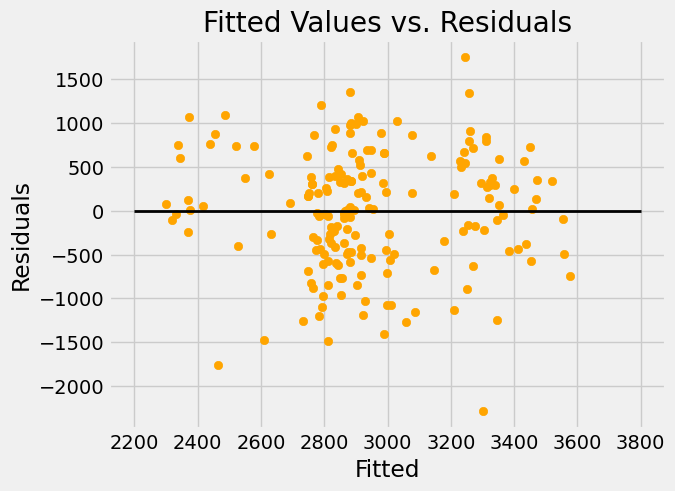

In [39]:
births_df['fitted'] = fitted_values
births_df['residuals'] = births_df.bwt - fitted_values

plt.scatter(births_df.fitted, births_df.residuals, color = 'orange')
plt.plot([2200,3800],[0,0],color="black",lw = 2)

plt.xlabel('Fitted')
plt.ylabel('Residuals')

plt.title("Fitted Values vs. Residuals")

plt.show()

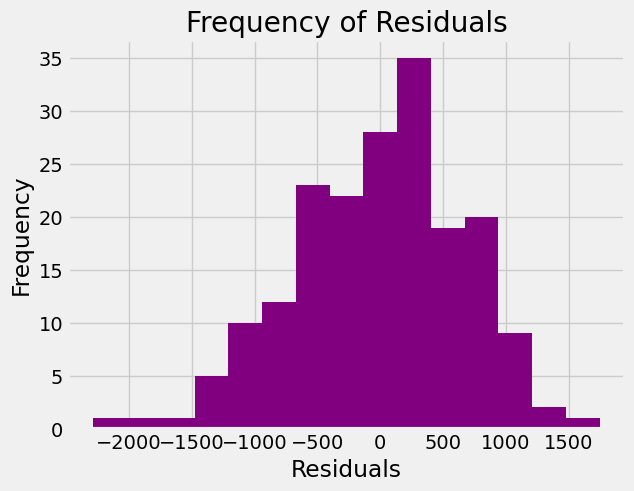

In [44]:
plt.hist(births_df['residuals'], bins = 15, color = 'purple')

plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.title('Frequency of Residuals')

plt.show()

I would say a linear regression model is appropriate for this dataset. The residuals exhibit randomness around zero in the scatterplot and follow a roughly symmetric bell-shaped distribution in the histogram, indicating that the assumptions of linear regression, such as constant variance of residuals and normality of residuals, are met. Therefore, the model captures the relationship between the predictor variables and the target variable adequately, providing reliable predictions.

**Question 10. (7pts)** Drop one variable that is not significant from your multiple regression model. Calculate the multiple linear regression line and compute the following:

**Use your line to predict a birthweight given someone who smokes, has checked the 'other' category for race, with lwt=150.**


**Calculate the adjusted R^2 for your model and compare it to your model in Q7. Does this give you a better idea of which model is better?**




In [52]:
'''Dropping 'Age' from my multiple regression model, based off the confidence intervals I calculated earlier'''

y1 = births_df['bwt']
X1 = births_df[['lwt', 'race_black', 'race_other', 'smoke']]

model = LinearRegression().fit(X1, y1)

intercept = model.intercept_
slopes = model.coef_

print(f"Multiple Regression Line: 𝑦̂ = {intercept} + {slopes[0]}*'lwt' + {slopes[1]}*'race_black' + {slopes[2]}*'race_other' + {slopes[3]}*'smoke'")


Multiple Regression Line: 𝑦̂ = 2799.284609332379 + 3.9376700677251493*'lwt' + -503.9139335023183*'race_black' + -394.9791757573307*'race_other' + -399.7724220088484*'smoke'


In [53]:
'''Birthweight given someone who smokes, has checked the 'other' category for race, with lwt=150'''

predicted_bwt = 2799.284609332379 + 3.9376700677251493*150 + -503.9139335023183*0 + -394.9791757573307*1 + -399.7724220088484*1

print(f'Final Answer: {predicted_bwt} grams')


Final Answer: 2595.1835217249723 grams


In [54]:
'''Adjusted R^2 for my model'''

r_squared = model.score(X1, y1)
n = len(births_df)
adjr_squared = 1-(n-1)/(n-(2))*(1-r_squared)
adjr_squared

print("Adjusted R^2 value:", r_squared)

Adjusted R^2 value: 0.14811560261261492


This adjusted R^2 value, 0.14811560261261492, is not very different from the original adjusted R^2 value, which included 'Age' (0.14829871160400032). Therefore, it's hard to say one model is better than the other.